# Lecture 16 - Multi-layer Perceptron (MLP)

***
##### CS 434 - Data Mining and Machine Learning
##### Oregon State University-Cascades
***

## <img src="https://img.icons8.com/color/32/000000/fork-lift.png"/> Loading packages

In [0]:
import os
import sys
import struct
import gzip
import shutil
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

## <img src="https://img.icons8.com/color/32/000000/hand-with-pen.png"/>  Load data

Use the scikit-learn API to load MNIST.

In [0]:
# load MNIST
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
y = y.astype(int)
X = ((X / 255.) - .5) * 2
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=10000, random_state=123, stratify=y)

In [0]:
# view shape
X_train.shape

(60000, 784)

Visualize the first digit of each class:

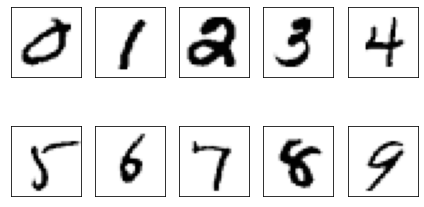

In [0]:
# visualize digits
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
    img = X_train[y_train == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

Visualize 25 different versions of "7":

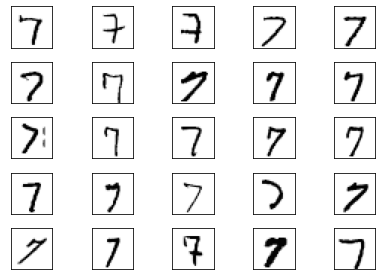

In [0]:
# show variants of digit 7
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(25):
    img = X_train[y_train == 7][i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

# <img src="https://img.icons8.com/color/32/000000/blueprint.png"/> Architecture

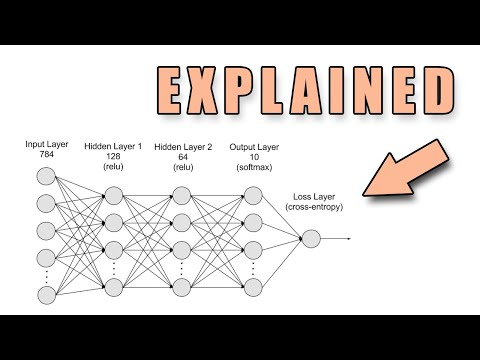

In [0]:
from IPython.display import YouTubeVideo
YouTubeVideo('AZEfmoWBXwg')

##  <img src="https://img.icons8.com/color/32/000000/one-page.png"/> Single-layer neural network architecture

<img src=https://raw.githubusercontent.com/rasbt/python-machine-learning-book-3rd-edition/master/ch12/images/12_01.png width="1000">

In the gradient descent optimization algorithm to learn the weight coefficients of the model.  In every epoch (pass over the dataset), we updated the weight vector $\mathbf{w}$ using the update:
$$\mathbf{w} := \mathbf{w} + \Delta \mathbf{w}$$
where $\Delta \textbf{w} =  -\eta \nabla J(\textbf{w})$.

We computed the gradient based on the whole training dataset and updated the weights of the model by taking a step into the opposite direction of the gradient $\nabla J(\textbf{w})$.

To find the optimal weights of the model, we optimized an objective function that we defined as the **sum of squared errors (SSE)** cost function $\nabla J(\textbf{w})$.  We multiplied the gradient by a factor, the **learning rate** $\eta$, which we had to choose carefully to balance the speed of learning against the risk of overshooting the global minimum of the cost function.

In gradient descent optimization, we updated all weights simultaneously after each epoch, and we defined the partial derivation for each weight $w_j$ in the weighted vector $\textbf{w}$ as follows:

$$\frac{\partial}{\partial w_j} J(\textbf{w}) = - \sum_i  (y^{i} - a^{i})\ x^{i}_{j} $$

where $y^i$ is the target class label of a particular sample $x^i$ and $a^i$ is the activation of the neuron, which is a linear function in the special case of Adaline.

Furthermore, we define the activation function $\phi(\cdot)$ as:

$$\phi(z) = z = a$$

Here, the net input $z$ is a linear combination of the weights that are connecting the input layer to the output layer:

$$z = \sum_j w_j x_j = \textbf{w}^T \textbf{x}$$

$$
 \hat{y} =\begin{cases}
    1 & \text{if $g(z) \ge 0$}\\
    -1 & \text{otherwise}
  \end{cases}
$$


##  <img src="https://img.icons8.com/color/32/000000/layers.png"/> Multi-layer neural network architecture

<img src=https://raw.githubusercontent.com/rasbt/python-machine-learning-book-3rd-edition/master/ch12/images/12_02.png width="1000">

The Multilayer Perceptron depicted above has one input layer, one hidden layer, and one output layer.  The units in the hidden layer are fully connected to the input layer, and the output layer is fully connected to the hidden layer.

If the network has more than one hidden layer, we might call it a **deep artificial neural network**.

### <img src="https://img.icons8.com/color/32/000000/quill-with-ink.png"/> Notation

<img src=https://raw.githubusercontent.com/rasbt/python-machine-learning-book-3rd-edition/master/ch12/images/12_03.png width="1000">

### <img src="https://img.icons8.com/color/32/000000/sorting-arrows.png"/> Activation functions

Linear:  $$g(z) = z$$ 

Unit step: $$g(z) = \begin{cases} 0 & z < 0, \\ 1 & z \ge 0 \end{cases}$$

Logistic (sigmoid): $$g(z) = \frac{1}{1 + e^{-z}}$$

Hyperbolic tangent: $$g(z) = tanh(z) = \frac{e^{z}-e^{-z}}{e^{z}+e^{-z}}$$


Piecewise linear: $$g(z) = \begin{cases}
 1 & \mbox{for } z \geq \frac{1}{2} \\
 z + \frac{1}{2} & \mbox{for } -\frac{1}{2} < z < \frac{1}{2} \\
 0 & \mbox{for } z \leq -\frac{1}{2}
 \end{cases}$$


In [0]:
# define activation functions
def activation(z, kind):
    
    implemented = ('linear', 'unit step', 'logistic', 'piecewise linear', 'tanh')
    if kind not in implemented:
        raise AttributeError('%s not in %s' % (kind, implemented))
    
    if kind == 'unit step':
        return np.where(z >= 0.0, 1, 0)
    
    elif kind == 'logistic':
        return 1.0 / (1.0 + np.exp(-z))
    
    elif kind == 'tanh':
        e_p = np.exp(z) 
        e_m = np.exp(-z)
        return (e_p - e_m) / (e_p + e_m)  
    
    elif kind == 'piecewise linear':
        if z >= 0.5:
            return 1
        elif z <= -0.5:
            return 0
        else:
            return z + 0.5
        
    else:
        return z

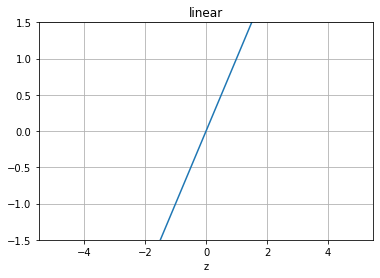

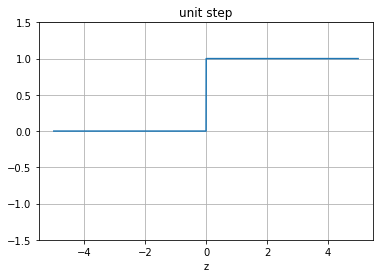

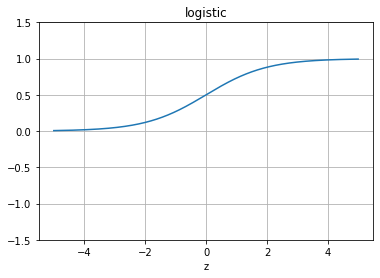

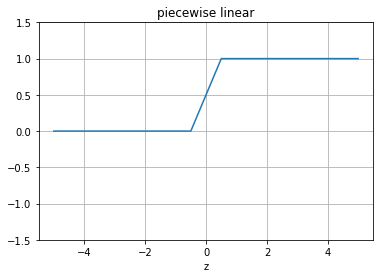

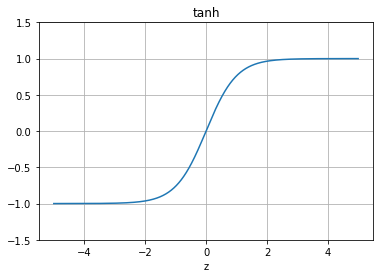

In [0]:
# visualize activation functions
x = np.arange(-5, 5, 0.005)
for a in ('linear', 'unit step', 'logistic', 'piecewise linear', 'tanh'):
    y = [activation(z, kind=a) for z in x]
    plt.plot(x, y)
    plt.title(a)
    plt.ylim([-1.5, 1.5])
    plt.xlabel('z')
    plt.grid()
    plt.show()

#### <img src="https://img.icons8.com/color/32/000000/formula-fx.png"/> Sigmoid function

<img src=https://raw.githubusercontent.com/rasbt/python-machine-learning-book-3rd-edition/master/ch12/images/12_04.png width="500">

# <img src="https://img.icons8.com/color/32/000000/artificial-intelligence.png"/>  Training neural networks

## <img src="https://img.icons8.com/color/32/000000/double-right.png"/> Forward Propagation

The MLP learning procedure:

1. Starting at the input layer, we forward propagate the patterns of the training data through the network to generate an output.

1. Based on the network's output, we calculate the error that we want to minimize using a cost function. 

1. We backpropogate the error, find its derivative with respect to each weight in the network, and update the model. 

## <img src="https://img.icons8.com/color/32/000000/full-tool-storage-box-.png"/> Implementing MLP

In [0]:
class NeuralNetMLP(object):
    """ Feedforward neural network / Multi-layer perceptron classifier.

    Parameters
    ------------
    n_hidden : int (default: 30)
        Number of hidden units.
    l2 : float (default: 0.)
        Lambda value for L2-regularization.
        No regularization if l2=0. (default)
    epochs : int (default: 100)
        Number of passes over the training set.
    eta : float (default: 0.001)
        Learning rate.
    shuffle : bool (default: True)
        Shuffles training data every epoch if True to prevent circles.
    minibatch_size : int (default: 1)
        Number of training examples per minibatch.
    seed : int (default: None)
        Random seed for initializing weights and shuffling.

    Attributes
    -----------
    eval_ : dict
      Dictionary collecting the cost, training accuracy,
      and validation accuracy for each epoch during training.

    """
    def __init__(self, n_hidden=30,
                 l2=0., epochs=100, eta=0.001,
                 shuffle=True, minibatch_size=1, seed=None):

        self.random = np.random.RandomState(seed)
        self.n_hidden = n_hidden
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.shuffle = shuffle
        self.minibatch_size = minibatch_size

    def _onehot(self, y, n_classes):
        """Encode labels into one-hot representation

        Parameters
        ------------
        y : array, shape = [n_examples]
            Target values.

        Returns
        -----------
        onehot : array, shape = (n_examples, n_labels)

        """
        onehot = np.zeros((n_classes, y.shape[0]))
        for idx, val in enumerate(y.astype(int)):
            onehot[val, idx] = 1.
        return onehot.T

    def _sigmoid(self, z):
        """Compute logistic function (sigmoid)"""
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))

    def _forward(self, X):
        """Compute forward propagation step"""

        # step 1: net input of hidden layer
        # [n_examples, n_features] dot [n_features, n_hidden]
        # -> [n_examples, n_hidden]
        z_h = np.dot(X, self.w_h) + self.b_h

        # step 2: activation of hidden layer
        a_h = self._sigmoid(z_h)

        # step 3: net input of output layer
        # [n_examples, n_hidden] dot [n_hidden, n_classlabels]
        # -> [n_examples, n_classlabels]

        z_out = np.dot(a_h, self.w_out) + self.b_out

        # step 4: activation output layer
        a_out = self._sigmoid(z_out)

        return z_h, a_h, z_out, a_out

    def _compute_cost(self, y_enc, output):
        """Compute cost function.

        Parameters
        ----------
        y_enc : array, shape = (n_examples, n_labels)
            one-hot encoded class labels.
        output : array, shape = [n_examples, n_output_units]
            Activation of the output layer (forward propagation)

        Returns
        ---------
        cost : float
            Regularized cost

        """
        L2_term = (self.l2 *
                   (np.sum(self.w_h ** 2.) +
                    np.sum(self.w_out ** 2.)))

        term1 = -y_enc * (np.log(output))
        term2 = (1. - y_enc) * np.log(1. - output)
        cost = np.sum(term1 - term2) + L2_term
        
        # If you are applying this cost function to other
        # datasets where activation
        # values maybe become more extreme (closer to zero or 1)
        # you may encounter "ZeroDivisionError"s due to numerical
        # instabilities in Python & NumPy for the current implementation.
        # I.e., the code tries to evaluate log(0), which is undefined.
        # To address this issue, you could add a small constant to the
        # activation values that are passed to the log function.
        #
        # For example:
        #
        # term1 = -y_enc * (np.log(output + 1e-5))
        # term2 = (1. - y_enc) * np.log(1. - output + 1e-5)
        
        return cost

    def predict(self, X):
        """Predict class labels

        Parameters
        -----------
        X : array, shape = [n_examples, n_features]
            Input layer with original features.

        Returns:
        ----------
        y_pred : array, shape = [n_examples]
            Predicted class labels.

        """
        z_h, a_h, z_out, a_out = self._forward(X)
        y_pred = np.argmax(z_out, axis=1)
        return y_pred

    def fit(self, X_train, y_train, X_valid, y_valid):
        """ Learn weights from training data.

        Parameters
        -----------
        X_train : array, shape = [n_examples, n_features]
            Input layer with original features.
        y_train : array, shape = [n_examples]
            Target class labels.
        X_valid : array, shape = [n_examples, n_features]
            Sample features for validation during training
        y_valid : array, shape = [n_examples]
            Sample labels for validation during training

        Returns:
        ----------
        self

        """
        n_output = np.unique(y_train).shape[0]  # number of class labels
        n_features = X_train.shape[1]

        ########################
        # Weight initialization
        ########################

        # weights for input -> hidden
        self.b_h = np.zeros(self.n_hidden)
        self.w_h = self.random.normal(loc=0.0, scale=0.1,
                                      size=(n_features, self.n_hidden))

        # weights for hidden -> output
        self.b_out = np.zeros(n_output)
        self.w_out = self.random.normal(loc=0.0, scale=0.1,
                                        size=(self.n_hidden, n_output))

        epoch_strlen = len(str(self.epochs))  # for progress formatting
        self.eval_ = {'cost': [], 'train_acc': [], 'valid_acc': []}

        y_train_enc = self._onehot(y_train, n_output)

        # iterate over training epochs
        for i in range(self.epochs):

            # iterate over minibatches
            indices = np.arange(X_train.shape[0])

            if self.shuffle:
                self.random.shuffle(indices)

            for start_idx in range(0, indices.shape[0] - self.minibatch_size +
                                   1, self.minibatch_size):
                batch_idx = indices[start_idx:start_idx + self.minibatch_size]

                # forward propagation
                z_h, a_h, z_out, a_out = self._forward(X_train[batch_idx])

                ##################
                # Backpropagation
                ##################

                # [n_examples, n_classlabels]
                delta_out = a_out - y_train_enc[batch_idx]

                # [n_examples, n_hidden]
                sigmoid_derivative_h = a_h * (1. - a_h)

                # [n_examples, n_classlabels] dot [n_classlabels, n_hidden]
                # -> [n_examples, n_hidden]
                delta_h = (np.dot(delta_out, self.w_out.T) *
                           sigmoid_derivative_h)

                # [n_features, n_examples] dot [n_examples, n_hidden]
                # -> [n_features, n_hidden]
                grad_w_h = np.dot(X_train[batch_idx].T, delta_h)
                grad_b_h = np.sum(delta_h, axis=0)

                # [n_hidden, n_examples] dot [n_examples, n_classlabels]
                # -> [n_hidden, n_classlabels]
                grad_w_out = np.dot(a_h.T, delta_out)
                grad_b_out = np.sum(delta_out, axis=0)

                # Regularization and weight updates
                delta_w_h = (grad_w_h + self.l2*self.w_h)
                delta_b_h = grad_b_h # bias is not regularized
                self.w_h -= self.eta * delta_w_h
                self.b_h -= self.eta * delta_b_h

                delta_w_out = (grad_w_out + self.l2*self.w_out)
                delta_b_out = grad_b_out  # bias is not regularized
                self.w_out -= self.eta * delta_w_out
                self.b_out -= self.eta * delta_b_out

            #############
            # Evaluation
            #############

            # Evaluation after each epoch during training
            z_h, a_h, z_out, a_out = self._forward(X_train)
            
            cost = self._compute_cost(y_enc=y_train_enc,
                                      output=a_out)

            y_train_pred = self.predict(X_train)
            y_valid_pred = self.predict(X_valid)

            train_acc = ((np.sum(y_train == y_train_pred)).astype(np.float) /
                         X_train.shape[0])
            valid_acc = ((np.sum(y_valid == y_valid_pred)).astype(np.float) /
                         X_valid.shape[0])

            sys.stderr.write('\r%0*d/%d | Cost: %.2f '
                             '| Train/Valid Acc.: %.2f%%/%.2f%% ' %
                             (epoch_strlen, i+1, self.epochs, cost,
                              train_acc*100, valid_acc*100))
            sys.stderr.flush()

            self.eval_['cost'].append(cost)
            self.eval_['train_acc'].append(train_acc)
            self.eval_['valid_acc'].append(valid_acc)

        return self

In [0]:
# set number of epochs
n_epochs = 200

* `l2` : the $\lambda$ parameter for L2 regularization to decrease the degree of overfitting.
* `epochs` : number of passes over the training dataset
* `eta` : the learning rate $\eta$
* `shuffle` : shuffle the training set prior to every epoch
* `seed` : random seed for shuffling and weight initialization
* `minibatch_size` : number of training examples in each minibatch

In [0]:
# build neural net
nn = NeuralNetMLP(n_hidden=100, 
                  l2=0.01, 
                  epochs=n_epochs, 
                  eta=0.0005,
                  minibatch_size=100, 
                  shuffle=True,
                  seed=1)

In [0]:
# train neural net
nn.fit(X_train=X_train[:55000], 
       y_train=y_train[:55000],
       X_valid=X_train[55000:],
       y_valid=y_train[55000:])

200/200 | Cost: 5016.68 | Train/Valid Acc.: 99.27%/97.38% 

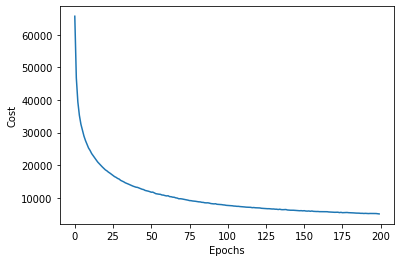

In [0]:
# plot cost over epochs
plt.plot(range(nn.epochs), nn.eval_['cost'])
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.show()

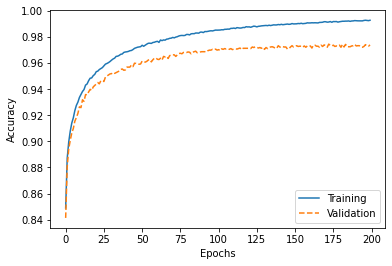

In [0]:
# plot accuracy over epochs
plt.plot(range(nn.epochs), nn.eval_['train_acc'], 
         label='Training')
plt.plot(range(nn.epochs), nn.eval_['valid_acc'], 
         label='Validation', linestyle='--')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
plt.show()

In [0]:
# predict test set
y_test_pred = nn.predict(X_test)
acc = (np.sum(y_test == y_test_pred)
       .astype(np.float) / X_test.shape[0])

print('Test accuracy: %.2f%%' % (acc * 100))

Test accuracy: 97.25%


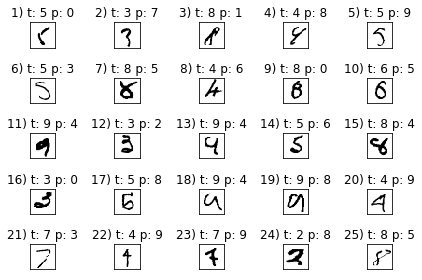

In [0]:
# visualize some results
miscl_img = X_test[y_test != y_test_pred][:25]
correct_lab = y_test[y_test != y_test_pred][:25]
miscl_lab = y_test_pred[y_test != y_test_pred][:25]

fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(25):
    img = miscl_img[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title('%d) t: %d p: %d' % (i+1, correct_lab[i], miscl_lab[i]))

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

## <img src="https://img.icons8.com/color/32/000000/estimate.png"/> Logistic cost function

<img src=https://raw.githubusercontent.com/rasbt/python-machine-learning-book-3rd-edition/master/ch12/images/12_10.png width="500">

## <img src="https://img.icons8.com/color/32/000000/rewind.png"/> Backpropagation

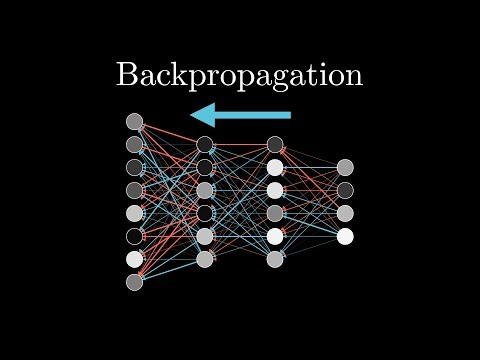

In [0]:
from IPython.display import YouTubeVideo
YouTubeVideo('Ilg3gGewQ5U')

## <img src="https://img.icons8.com/color/32/000000/training.png"/> Training  via backpropagation

<img src=https://raw.githubusercontent.com/rasbt/python-machine-learning-book-3rd-edition/master/ch12/images/12_11.png width="1000">

<img src=https://raw.githubusercontent.com/rasbt/python-machine-learning-book-3rd-edition/master/ch12/images/12_12.png width="1000">

# <img src="https://img.icons8.com/color/32/000000/minimum-value.png"/> Convergence in neural networks

<img src=https://raw.githubusercontent.com/rasbt/python-machine-learning-book-3rd-edition/master/ch12/images/12_13.png width="1000">